# This notebook details the analysis done on the use of Convolutional Neural Network for evaluating windows OS Security<br>
## The notebook implements, the modules that deal with data preprocessing, Hyper Parameter Optimization, Evauation of Best models, creating classification reports as well as saving the best configuration

In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
import time, os, psutil
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


## Reading the CSV file containing the input and output data

In [2]:
df = pd.read_csv("expert_system_simulation.csv")

In [3]:
df.head()

,adr,tcp_rate,icmp_rate,all_profiles,IPSecProfile,firewall_rule,event_set_1,event_set_2,event_set_3,event_set_4,bap,upd,pub,pmpe,password_strength,score
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,10
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,9
2,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,8
3,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,7
4,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,8


## Replacing the True/False Variables with binary values i.e. 0/1

In [4]:
df.replace(False, 0, inplace=True)
df.replace(True, 1, inplace=True)

In [5]:
df.head()

,adr,tcp_rate,icmp_rate,all_profiles,IPSecProfile,firewall_rule,event_set_1,event_set_2,event_set_3,event_set_4,bap,upd,pub,pmpe,password_strength,score
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,8
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,8


## The Code Snippet below checks for the count of each multi-class label to identify Class Imbalance

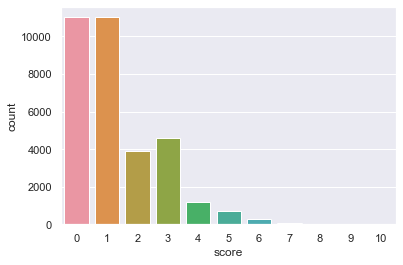

In [6]:
def op_class_labels(df: pd.DataFrame, target: str) -> None:
    sns.set(style="darkgrid")
    ax = sns.countplot(x=target, data=df)
    plt.show()
op_class_labels(df, "score")


In [7]:
df.groupby("score").count().reset_index()

,score,adr,tcp_rate,icmp_rate,all_profiles,IPSecProfile,firewall_rule,event_set_1,event_set_2,event_set_3,event_set_4,bap,upd,pub,pmpe,password_strength
0,0,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025
1,1,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025
2,2,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885
3,3,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620,4620
4,4,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170
5,5,694,694,694,694,694,694,694,694,694,694,694,694,694,694,694
6,6,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274
7,7,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
8,8,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
9,9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Upsampling the input Dataset to solve the class imbalance problem

In [8]:
def upsampling(df, column_list, thresh):
    extender_list = []
    for cols in column_list:
        counter = int(thresh/(df[df["score"]==cols].shape[0]/df.shape[0]))
        for ctr in range(counter):
            extender_list.append(df[df["score"]==cols])
    extender_df = pd.concat(extender_list)
    return df.append(extender_df)
df = upsampling(df, [4, 5, 6, 7, 8, 9, 10], 0.1)

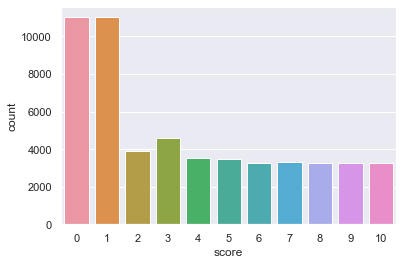

In [9]:
op_class_labels(df, "score")

### Shuffling the dataset to break any serial correlations in the dataset

In [10]:

df = shuffle(df)
df.head()

,adr,tcp_rate,icmp_rate,all_profiles,IPSecProfile,firewall_rule,event_set_1,event_set_2,event_set_3,event_set_4,bap,upd,pub,pmpe,password_strength,score
25237,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0
11032,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1
25510,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1
32399,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
13951,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Reshaping the dataset and creating train and test datasets

In [11]:
df_ip = df[df.columns.tolist()[:-1]]
df_ip["dummy"] = 1
df_ip.shape

(53954, 16)

In [12]:
ip_set = np.reshape(df_ip.values,  (df_ip.shape[0], 4, 4))

In [13]:

op_set = df["score"].values

In [14]:
# creating training, testing and validation sets
x_train, x_test, y_train, y_test = tts(ip_set, op_set, test_size=0.2, random_state=1)


## Assigning values to the input and output variables of the CNN

In [15]:

# create CNN model
# Model / data parameters
num_classes = 11
input_shape = (4, 4, 1)

In [16]:

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [17]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (43163, 4, 4, 1)
43163 train samples
10791 test samples


## One Hot Encoding the output to ensure better training procedure

In [18]:
# One Hot Encode the input variables
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Creating a two layered (hidden) Convolutional Neural Network

In [19]:
def create_model(num_filters, activation_func):
    """
    This function takes in two inputs of number of filters, and
    choice of activation function, and delivers a compiled CNN
    model to be Trained
    """
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(num_filters, kernel_size=(2, 2), activation=activation_func),
        layers.MaxPooling2D(pool_size=(1, 1)),
        layers.Conv2D(num_filters*2, kernel_size=(2, 2), activation=activation_func),
        layers.MaxPooling2D(pool_size=(1, 1)),
        layers.Flatten(),
        layers.Dropout(0.05),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.summary()
    return model

In [20]:
batch_size = 128 # Fixed Batch size of inputs
epochs = 40 # number of iterations/epochs
def run_hpo(num_filters, activcation_func):
    """
    This function takes in two inputs of number of filters, and
    choice of activation function, and trains the model along with
    recording performance metrics
    """
    save_dict = {}
    model = create_model(num_filters, activation_func)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t1 = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    t2 = time.time()
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    preds = model.predict(x_test)
    process = psutil.Process(os.getpid())
    
    save_dict = {"param_config": f"num_filters = {num_filters}, activcation_func = {activation_func}", 
                 "Test loss": score[0], "Test accuracy": score[1], "preds": preds, "history":history,
                "exec_time_seconds":t2-t1, "memory_resource":process.memory_info().rss}
    
    return save_dict

## Performing Hyper Parameter OPtimization

In [21]:
num_filters = [8, 16, 32, 64, 128]
# num_filters = [8, 16]
activation_func_list = ["relu", "elu", "tanh", "sigmoid", "selu"]
hpo_list = []
for filters in num_filters:
    for activation_func in activation_func_list:
        run_res = run_hpo(filters, activation_func)
        hpo_list.append(run_res)
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 8)           40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 16)          528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 11)                7

270/270 [==============================] - 1s 3ms/step - loss: 1.8220 - accuracy: 0.4380 - val_loss: 1.2109 - val_accuracy: 0.5780
Epoch 2/40
270/270 [==============================] - 1s 3ms/step - loss: 1.0309 - accuracy: 0.6366 - val_loss: 0.9120 - val_accuracy: 0.6721
Epoch 3/40
270/270 [==============================] - 1s 3ms/step - loss: 0.8717 - accuracy: 0.6934 - val_loss: 0.8150 - val_accuracy: 0.7109
Epoch 4/40
270/270 [==============================] - 1s 3ms/step - loss: 0.7995 - accuracy: 0.7154 - val_loss: 0.7554 - val_accuracy: 0.7292
Epoch 5/40
270/270 [==============================] - 1s 3ms/step - loss: 0.7436 - accuracy: 0.7362 - val_loss: 0.7035 - val_accuracy: 0.7391
Epoch 6/40
270/270 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.75 - 1s 3ms/step - loss: 0.6884 - accuracy: 0.7560 - val_loss: 0.6415 - val_accuracy: 0.7873
Epoch 7/40
270/270 [==============================] - 1s 3ms/step - loss: 0.6264 - accuracy: 0.7780 - val_loss: 0.569

270/270 [==============================] - 1s 3ms/step - loss: 0.5852 - accuracy: 0.7969 - val_loss: 0.5426 - val_accuracy: 0.8128
Epoch 9/40
270/270 [==============================] - 1s 3ms/step - loss: 0.5405 - accuracy: 0.8094 - val_loss: 0.4968 - val_accuracy: 0.8359
Epoch 10/40
270/270 [==============================] - 1s 2ms/step - loss: 0.5030 - accuracy: 0.8223 - val_loss: 0.4610 - val_accuracy: 0.8521
Epoch 11/40
270/270 [==============================] - 1s 3ms/step - loss: 0.4710 - accuracy: 0.8341 - val_loss: 0.4232 - val_accuracy: 0.8666
Epoch 12/40
270/270 [==============================] - 1s 2ms/step - loss: 0.4396 - accuracy: 0.8453 - val_loss: 0.3957 - val_accuracy: 0.8698
Epoch 13/40
270/270 [==============================] - 1s 2ms/step - loss: 0.4180 - accuracy: 0.8500 - val_loss: 0.3703 - val_accuracy: 0.8860
Epoch 14/40
270/270 [==============================] - 1s 2ms/step - loss: 0.3944 - accuracy: 0.8617 - val_loss: 0.3507 - val_accuracy: 0.8852
Epoch 15/40


270/270 [==============================] - 1s 2ms/step - loss: 0.7760 - accuracy: 0.7152 - val_loss: 0.7446 - val_accuracy: 0.7178
Epoch 17/40
270/270 [==============================] - 1s 2ms/step - loss: 0.7535 - accuracy: 0.7221 - val_loss: 0.7248 - val_accuracy: 0.7283
Epoch 18/40
270/270 [==============================] - 1s 2ms/step - loss: 0.7351 - accuracy: 0.7287 - val_loss: 0.7030 - val_accuracy: 0.7357
Epoch 19/40
270/270 [==============================] - 1s 2ms/step - loss: 0.7150 - accuracy: 0.7370 - val_loss: 0.6835 - val_accuracy: 0.7484
Epoch 20/40
270/270 [==============================] - 1s 2ms/step - loss: 0.6955 - accuracy: 0.7424 - val_loss: 0.6624 - val_accuracy: 0.7550
Epoch 21/40
270/270 [==============================] - 1s 2ms/step - loss: 0.6750 - accuracy: 0.7510 - val_loss: 0.6428 - val_accuracy: 0.7570
Epoch 22/40
270/270 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.7558 - val_loss: 0.6233 - val_accuracy: 0.7665
Epoch 23/40

270/270 [==============================] - 1s 3ms/step - loss: 0.2412 - accuracy: 0.9157 - val_loss: 0.1672 - val_accuracy: 0.9525
Epoch 25/40
270/270 [==============================] - 1s 2ms/step - loss: 0.2389 - accuracy: 0.9153 - val_loss: 0.1648 - val_accuracy: 0.9531
Epoch 26/40
270/270 [==============================] - 1s 2ms/step - loss: 0.2317 - accuracy: 0.9195 - val_loss: 0.1575 - val_accuracy: 0.9531
Epoch 27/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2262 - accuracy: 0.9188 - val_loss: 0.1509 - val_accuracy: 0.9563
Epoch 28/40
270/270 [==============================] - 1s 2ms/step - loss: 0.2194 - accuracy: 0.9211 - val_loss: 0.1441 - val_accuracy: 0.9582
Epoch 29/40
270/270 [==============================] - 1s 2ms/step - loss: 0.2150 - accuracy: 0.9243 - val_loss: 0.1453 - val_accuracy: 0.9562
Epoch 30/40
270/270 [==============================] - 1s 2ms/step - loss: 0.2093 - accuracy: 0.9253 - val_loss: 0.1346 - val_accuracy: 0.9612
Epoch 31/40

Epoch 32/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0870 - accuracy: 0.9701 - val_loss: 0.0530 - val_accuracy: 0.9841
Epoch 33/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0860 - accuracy: 0.9709 - val_loss: 0.0523 - val_accuracy: 0.9845
Epoch 34/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 0.0508 - val_accuracy: 0.9832
Epoch 35/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0847 - accuracy: 0.9710 - val_loss: 0.0506 - val_accuracy: 0.9842
Epoch 36/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0816 - accuracy: 0.9726 - val_loss: 0.0504 - val_accuracy: 0.9831
Epoch 37/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0791 - accuracy: 0.9729 - val_loss: 0.0472 - val_accuracy: 0.9852
Epoch 38/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0798 - accuracy: 0.9730 - val_loss: 0.0475 - val_accuracy: 0.9846

Epoch 40/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0819 - accuracy: 0.9703 - val_loss: 0.0486 - val_accuracy: 0.9854
Test loss: 0.05229787528514862
Test accuracy: 0.9833194613456726
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 3, 3, 16)          80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 2, 2, 32)          2080      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
____________________________________________

270/270 [==============================] - 1s 3ms/step - loss: 2.2142 - accuracy: 0.2198 - val_loss: 2.0382 - val_accuracy: 0.3584
Epoch 2/40
270/270 [==============================] - 1s 3ms/step - loss: 1.7754 - accuracy: 0.3604 - val_loss: 1.5937 - val_accuracy: 0.4124
Epoch 3/40
270/270 [==============================] - 1s 3ms/step - loss: 1.4898 - accuracy: 0.4998 - val_loss: 1.3243 - val_accuracy: 0.5840
Epoch 4/40
270/270 [==============================] - 1s 3ms/step - loss: 1.2030 - accuracy: 0.6052 - val_loss: 1.0765 - val_accuracy: 0.6155
Epoch 5/40
270/270 [==============================] - 1s 3ms/step - loss: 1.0373 - accuracy: 0.6365 - val_loss: 0.9796 - val_accuracy: 0.6460
Epoch 6/40
270/270 [==============================] - 1s 3ms/step - loss: 0.9637 - accuracy: 0.6553 - val_loss: 0.9218 - val_accuracy: 0.6685
Epoch 7/40
270/270 [==============================] - 1s 3ms/step - loss: 0.9158 - accuracy: 0.6725 - val_loss: 0.8801 - val_accuracy: 0.6841
Epoch 8/40
270/27

270/270 [==============================] - 1s 3ms/step - loss: 0.3627 - accuracy: 0.8699 - val_loss: 0.3013 - val_accuracy: 0.9112
Epoch 10/40
270/270 [==============================] - 1s 3ms/step - loss: 0.3209 - accuracy: 0.8884 - val_loss: 0.2594 - val_accuracy: 0.9252
Epoch 11/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2889 - accuracy: 0.9006 - val_loss: 0.2332 - val_accuracy: 0.9337
Epoch 12/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2609 - accuracy: 0.9115 - val_loss: 0.2070 - val_accuracy: 0.9430
Epoch 13/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2367 - accuracy: 0.9191 - val_loss: 0.1830 - val_accuracy: 0.9452
Epoch 14/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2192 - accuracy: 0.9252 - val_loss: 0.1651 - val_accuracy: 0.9541
Epoch 15/40
270/270 [==============================] - 1s 3ms/step - loss: 0.2040 - accuracy: 0.9291 - val_loss: 0.1507 - val_accuracy: 0.9600
Epoch 16/40

270/270 [==============================] - 1s 4ms/step - loss: 0.0758 - accuracy: 0.9740 - val_loss: 0.0520 - val_accuracy: 0.9833
Epoch 18/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0725 - accuracy: 0.9752 - val_loss: 0.0539 - val_accuracy: 0.9831
Epoch 19/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0683 - accuracy: 0.9764 - val_loss: 0.0481 - val_accuracy: 0.9844
Epoch 20/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0682 - accuracy: 0.9761 - val_loss: 0.0460 - val_accuracy: 0.9840
Epoch 21/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0640 - accuracy: 0.9772 - val_loss: 0.0452 - val_accuracy: 0.9864
Epoch 22/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0615 - accuracy: 0.9777 - val_loss: 0.0450 - val_accuracy: 0.9839
Epoch 23/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0613 - accuracy: 0.9783 - val_loss: 0.0474 - val_accuracy: 0.9841
Epoch 24/40

270/270 [==============================] - 1s 4ms/step - loss: 0.0719 - accuracy: 0.9749 - val_loss: 0.0487 - val_accuracy: 0.9848
Epoch 26/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 0.9764 - val_loss: 0.0449 - val_accuracy: 0.9847
Epoch 27/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0682 - accuracy: 0.9751 - val_loss: 0.0467 - val_accuracy: 0.9830
Epoch 28/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0691 - accuracy: 0.9747 - val_loss: 0.0432 - val_accuracy: 0.9851
Epoch 29/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0650 - accuracy: 0.9766 - val_loss: 0.0447 - val_accuracy: 0.9856
Epoch 30/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0646 - accuracy: 0.9766 - val_loss: 0.0424 - val_accuracy: 0.9848
Epoch 31/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0620 - accuracy: 0.9765 - val_loss: 0.0398 - val_accuracy: 0.9858
Epoch 32/40

270/270 [==============================] - 1s 3ms/step - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.0459 - val_accuracy: 0.9870
Epoch 34/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0623 - accuracy: 0.9792 - val_loss: 0.0500 - val_accuracy: 0.9834
Epoch 35/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0611 - accuracy: 0.9791 - val_loss: 0.0442 - val_accuracy: 0.9866
Epoch 36/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0603 - accuracy: 0.9800 - val_loss: 0.0449 - val_accuracy: 0.9849
Epoch 37/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0608 - accuracy: 0.9800 - val_loss: 0.0430 - val_accuracy: 0.9864
Epoch 38/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0597 - accuracy: 0.9801 - val_loss: 0.0427 - val_accuracy: 0.9860
Epoch 39/40
270/270 [==============================] - 1s 4ms/step - loss: 0.0582 - accuracy: 0.9809 - val_loss: 0.0426 - val_accuracy: 0.9869
Epoch 40/40

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 3, 3, 32)          160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 11)              

270/270 [==============================] - 2s 6ms/step - loss: 1.0613 - accuracy: 0.6477 - val_loss: 0.6446 - val_accuracy: 0.7718
Epoch 2/40
270/270 [==============================] - 1s 5ms/step - loss: 0.5323 - accuracy: 0.8063 - val_loss: 0.4083 - val_accuracy: 0.8667
Epoch 3/40
270/270 [==============================] - 1s 5ms/step - loss: 0.3669 - accuracy: 0.8667 - val_loss: 0.3001 - val_accuracy: 0.8966
Epoch 4/40
270/270 [==============================] - 1s 5ms/step - loss: 0.2734 - accuracy: 0.9017 - val_loss: 0.2096 - val_accuracy: 0.9292
Epoch 5/40
270/270 [==============================] - 2s 6ms/step - loss: 0.2024 - accuracy: 0.9321 - val_loss: 0.1502 - val_accuracy: 0.9560
Epoch 6/40
270/270 [==============================] - 1s 5ms/step - loss: 0.1579 - accuracy: 0.9459 - val_loss: 0.1219 - val_accuracy: 0.9650
Epoch 7/40
270/270 [==============================] - 1s 5ms/step - loss: 0.1306 - accuracy: 0.9553 - val_loss: 0.1030 - val_accuracy: 0.9665
Epoch 8/40
270/27

270/270 [==============================] - 1s 6ms/step - loss: 0.1064 - accuracy: 0.9648 - val_loss: 0.0868 - val_accuracy: 0.9722
Epoch 10/40
270/270 [==============================] - 2s 6ms/step - loss: 0.0964 - accuracy: 0.9676 - val_loss: 0.0756 - val_accuracy: 0.9774
Epoch 11/40
270/270 [==============================] - 2s 6ms/step - loss: 0.0892 - accuracy: 0.9694 - val_loss: 0.0695 - val_accuracy: 0.9772
Epoch 12/40
270/270 [==============================] - 1s 6ms/step - loss: 0.0780 - accuracy: 0.9719 - val_loss: 0.0604 - val_accuracy: 0.9812
Epoch 13/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0747 - accuracy: 0.9738 - val_loss: 0.0551 - val_accuracy: 0.9822
Epoch 14/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0704 - accuracy: 0.9756 - val_loss: 0.0605 - val_accuracy: 0.9773
Epoch 15/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0690 - accuracy: 0.9754 - val_loss: 0.0495 - val_accuracy: 0.9834
Epoch 16/40

Epoch 17/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0622 - accuracy: 0.9807 - val_loss: 0.0519 - val_accuracy: 0.9834
Epoch 18/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0592 - accuracy: 0.9822 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 19/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0566 - accuracy: 0.9818 - val_loss: 0.0490 - val_accuracy: 0.9855
Epoch 20/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0559 - accuracy: 0.9814 - val_loss: 0.0428 - val_accuracy: 0.9848
Epoch 21/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0551 - accuracy: 0.9831 - val_loss: 0.0427 - val_accuracy: 0.9858
Epoch 22/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0526 - accuracy: 0.9828 - val_loss: 0.0442 - val_accuracy: 0.9858
Epoch 23/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0507 - accuracy: 0.9836 - val_loss: 0.0408 - val_accuracy: 0.9851

Epoch 25/40
270/270 [==============================] - 1s 5ms/step - loss: 0.1191 - accuracy: 0.9692 - val_loss: 0.1034 - val_accuracy: 0.9761
Epoch 26/40
270/270 [==============================] - 1s 5ms/step - loss: 0.1126 - accuracy: 0.9694 - val_loss: 0.0974 - val_accuracy: 0.9772
Epoch 27/40
270/270 [==============================] - 1s 5ms/step - loss: 0.1052 - accuracy: 0.9713 - val_loss: 0.0908 - val_accuracy: 0.9783
Epoch 28/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0994 - accuracy: 0.9734 - val_loss: 0.0889 - val_accuracy: 0.9787
Epoch 29/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0944 - accuracy: 0.9740 - val_loss: 0.0817 - val_accuracy: 0.9793
Epoch 30/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0899 - accuracy: 0.9742 - val_loss: 0.0780 - val_accuracy: 0.9788
Epoch 31/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0851 - accuracy: 0.9758 - val_loss: 0.0758 - val_accuracy: 0.9805

Epoch 33/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0518 - accuracy: 0.9813 - val_loss: 0.0363 - val_accuracy: 0.9856
Epoch 34/40
270/270 [==============================] - 2s 6ms/step - loss: 0.0512 - accuracy: 0.9809 - val_loss: 0.0412 - val_accuracy: 0.9837
Epoch 35/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0487 - accuracy: 0.9822 - val_loss: 0.0424 - val_accuracy: 0.9846
Epoch 36/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0480 - accuracy: 0.9823 - val_loss: 0.0362 - val_accuracy: 0.9873
Epoch 37/40
270/270 [==============================] - 2s 6ms/step - loss: 0.0485 - accuracy: 0.9820 - val_loss: 0.0386 - val_accuracy: 0.9855
Epoch 38/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0503 - accuracy: 0.9820 - val_loss: 0.0437 - val_accuracy: 0.9842
Epoch 39/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0485 - accuracy: 0.9822 - val_loss: 0.0362 - val_accuracy: 0.9867

270/270 [==============================] - 3s 13ms/step - loss: 0.0339 - accuracy: 0.9866 - val_loss: 0.0362 - val_accuracy: 0.9863
Test loss: 0.040457289665937424
Test accuracy: 0.985821545124054
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 3, 3, 128)         640       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 2, 2, 256)         131328    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1024)              0         
______________________________________________________

270/270 [==============================] - 4s 13ms/step - loss: 1.0419 - accuracy: 0.6499 - val_loss: 0.7833 - val_accuracy: 0.7329
Epoch 2/40
270/270 [==============================] - 3s 13ms/step - loss: 0.6603 - accuracy: 0.7539 - val_loss: 0.5431 - val_accuracy: 0.8186
Epoch 3/40
270/270 [==============================] - 4s 13ms/step - loss: 0.4062 - accuracy: 0.8564 - val_loss: 0.2991 - val_accuracy: 0.9124
Epoch 4/40
270/270 [==============================] - 4s 13ms/step - loss: 0.2518 - accuracy: 0.9239 - val_loss: 0.2011 - val_accuracy: 0.9461
Epoch 5/40
270/270 [==============================] - 3s 13ms/step - loss: 0.1731 - accuracy: 0.9509 - val_loss: 0.1389 - val_accuracy: 0.9673
Epoch 6/40
270/270 [==============================] - 4s 13ms/step - loss: 0.1295 - accuracy: 0.9641 - val_loss: 0.1014 - val_accuracy: 0.9753
Epoch 7/40
270/270 [==============================] - 4s 13ms/step - loss: 0.1041 - accuracy: 0.9716 - val_loss: 0.0957 - val_accuracy: 0.9716
Epoch 8/40

Epoch 9/40
270/270 [==============================] - 3s 13ms/step - loss: 0.4321 - accuracy: 0.8529 - val_loss: 0.3887 - val_accuracy: 0.8740
Epoch 10/40
270/270 [==============================] - 4s 13ms/step - loss: 0.3659 - accuracy: 0.8823 - val_loss: 0.3417 - val_accuracy: 0.8874
Epoch 11/40
270/270 [==============================] - 4s 13ms/step - loss: 0.3105 - accuracy: 0.9031 - val_loss: 0.2718 - val_accuracy: 0.9227
Epoch 12/40
270/270 [==============================] - 3s 13ms/step - loss: 0.2663 - accuracy: 0.9219 - val_loss: 0.2354 - val_accuracy: 0.9392
Epoch 13/40
270/270 [==============================] - 3s 13ms/step - loss: 0.2319 - accuracy: 0.9323 - val_loss: 0.2025 - val_accuracy: 0.9496
Epoch 14/40
270/270 [==============================] - 4s 13ms/step - loss: 0.2033 - accuracy: 0.9431 - val_loss: 0.1764 - val_accuracy: 0.9582
Epoch 15/40
270/270 [==============================] - 4s 13ms/step - loss: 0.1773 - accuracy: 0.9516 - val_loss: 0.1575 - val_accuracy: 

270/270 [==============================] - 4s 13ms/step - loss: 0.0664 - accuracy: 0.9750 - val_loss: 0.0536 - val_accuracy: 0.9803
Epoch 17/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0682 - accuracy: 0.9749 - val_loss: 0.0580 - val_accuracy: 0.9819
Epoch 18/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0678 - accuracy: 0.9752 - val_loss: 0.0541 - val_accuracy: 0.9803
Epoch 19/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0624 - accuracy: 0.9779 - val_loss: 0.0474 - val_accuracy: 0.9814
Epoch 20/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0592 - accuracy: 0.9790 - val_loss: 0.0481 - val_accuracy: 0.9832
Epoch 21/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0599 - accuracy: 0.9781 - val_loss: 0.0400 - val_accuracy: 0.9847
Epoch 22/40
270/270 [==============================] - 4s 13ms/step - loss: 0.0593 - accuracy: 0.9782 - val_loss: 0.0474 - val_accuracy: 0.9791
Epoc

## Post Processing the results; based on the runs of the Hyper Parameter OPtimization

In [22]:
param_config, train_loss, validation_loss, test_loss, train_accuracy, validation_accuracy, test_accuracy  = [], [], [], [], [], [], []
run_time, memory_consumption = [], []
for hpo in hpo_list:
    param_config.append(hpo["param_config"])
    train_loss.append(hpo["history"].history['loss'][-1])
    validation_loss.append(hpo["history"].history['val_loss'][-1])
    test_loss.append(hpo["Test loss"]) 
    train_accuracy.append(hpo["history"].history['accuracy'][-1])
    validation_accuracy.append(hpo["history"].history['val_accuracy'][-1]) 
    test_accuracy.append(hpo["Test accuracy"])
    run_time.append(hpo["exec_time_seconds"])
    memory_consumption.append(hpo["memory_resource"])



perf_df = pd.DataFrame({"param_config":param_config , "train_loss":train_loss, "validation_loss":validation_loss, 
"test_loss":test_loss, "train_accuracy":train_accuracy, "validation_accuracy":validation_accuracy, 
"test_accuracy":test_accuracy, "run_time":run_time, "memory_consumption":memory_consumption})
    


In [23]:
perf_df = perf_df.sort_values("test_accuracy", ascending=False)
perf_df.to_csv("hpo_performance.csv")

## The table below indicates the outputs of the post processed results form the Hyper Parameter Optimization

In [24]:
perf_df.head(30)

,param_config,train_loss,validation_loss,test_loss,train_accuracy,validation_accuracy,test_accuracy,run_time,memory_consumption
15,"num_filters = 64, activcation_func = relu",0.037354,0.028130,0.032644,0.985636,0.988417,0.986748,60.268739,609492992
14,"num_filters = 32, activcation_func = selu",0.060078,0.037115,0.039930,0.978164,0.985984,0.986007,43.583657,586416128
11,"num_filters = 32, activcation_func = elu",0.056213,0.033487,0.036379,0.979786,0.988532,0.985914,43.063758,516395008
20,"num_filters = 128, activcation_func = relu",0.033920,0.036205,0.040457,0.986620,0.986332,0.985822,138.846109,675880960
21,"num_filters = 128, activcation_func = elu",0.043769,0.034543,0.036423,0.984564,0.986911,0.985729,147.945723,701837312
23,"num_filters = 128, activcation_func = sigmoid",0.045678,0.039355,0.041733,0.983753,0.987490,0.984987,142.080732,687095808
17,"num_filters = 64, activcation_func = tanh",0.040606,0.033787,0.035892,0.985838,0.987490,0.984987,56.009275,596938752
10,"num_filters = 32, activcation_func = relu",0.044659,0.035873,0.037032,0.983203,0.985868,0.984524,41.331090,502206464
5,"num_filters = 16, activcation_func = relu",0.076847,0.044894,0.047393,0.973096,0.985405,0.984246,30.207164,433971200
12,"num_filters = 32, activcation_func = tanh",0.057969,0.040556,0.042708,0.981494,0.985057,0.984153,40.558011,538611712


## Generating the classification report of the best Run/Configuration

In [25]:
# Generates the classification report for a specific (best) config
from sklearn.metrics import classification_report
y_pred_bool = np.argmax(hpo_list[15]["preds"], axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2210
           1       0.98      1.00      0.99      2255
           2       0.94      0.97      0.96       762
           3       0.99      0.94      0.97       950
           4       0.98      0.98      0.98       722
           5       0.98      1.00      0.99       683
           6       0.99      0.99      0.99       617
           7       1.00      1.00      1.00       676
           8       0.99      1.00      1.00       657
           9       1.00      1.00      1.00       594
          10       1.00      1.00      1.00       665

    accuracy                           0.99     10791
   macro avg       0.99      0.99      0.99     10791
weighted avg       0.99      0.99      0.99     10791



In [29]:
def gen_sns_line_plots(hpo_list, index_val):
    """
    This Function Plots the training and validation
    of the 4 best configurations
    """
    df1 = pd.DataFrame({"epochs": [x for x in range(1, len(hpo_list[index_val]["history"].history["val_accuracy"])+1)],
                        "accuracy":hpo_list[index_val]["history"].history["accuracy"],
                       "cross_entropy_loss":hpo_list[index_val]["history"].history["loss"]})
    df1["type"] = "Training"
    df2 = pd.DataFrame({"epochs": [x for x in range(1, len(hpo_list[index_val]["history"].history["val_accuracy"])+1)],
                        "accuracy":hpo_list[index_val]["history"].history["val_accuracy"],
                       "cross_entropy_loss":hpo_list[index_val]["history"].history["val_loss"]})
    df2["type"] = "validation"
    df = df1.append(df2)
    plt.figure()
    sns.lineplot('epochs', 'accuracy', ci=None, 
             hue='type', data=df)
    plt.title(f'Train and Validation accuracy for: {hpo_list[index_val]["param_config"]}')
    plt.figure()
    sns.lineplot('epochs', 'cross_entropy_loss', ci=None, 
             hue='type', data=df)
    plt.title(f'Train and Validation loss for: {hpo_list[index_val]["param_config"]}')






## Plots for Best Configuration

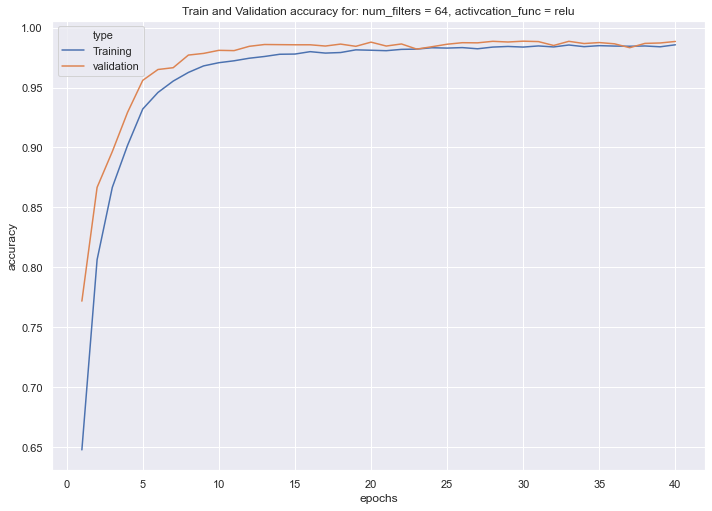

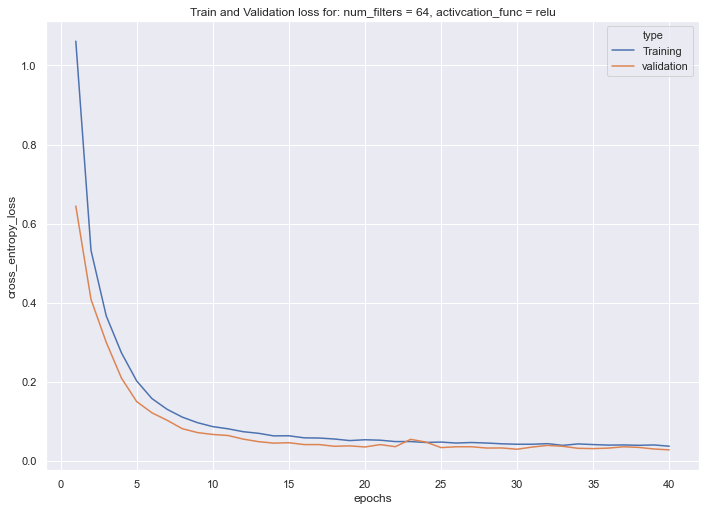

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
gen_sns_line_plots(hpo_list, 15)

## Plots for Second Best Configuration

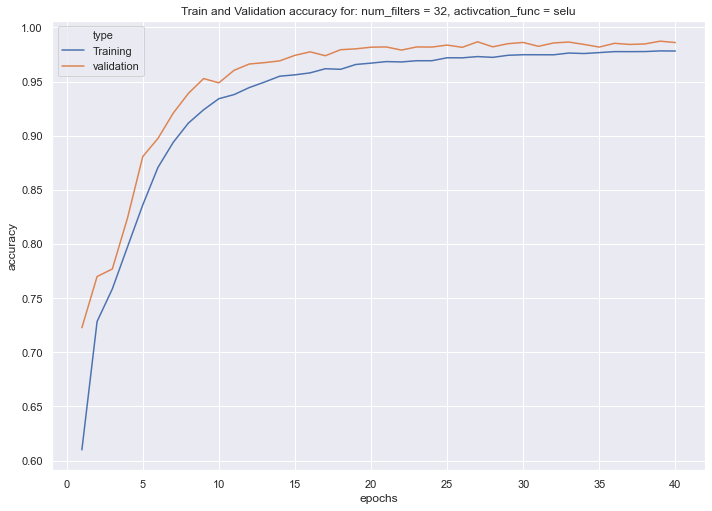

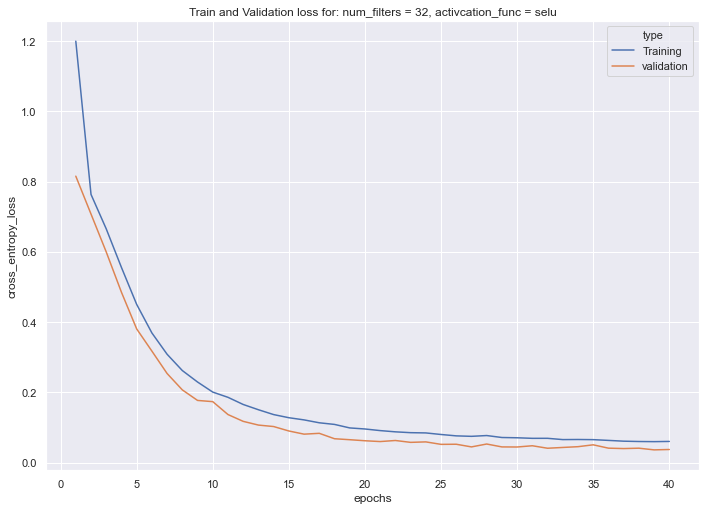

In [31]:
gen_sns_line_plots(hpo_list, 14)

## Plots for Third Best Configuration

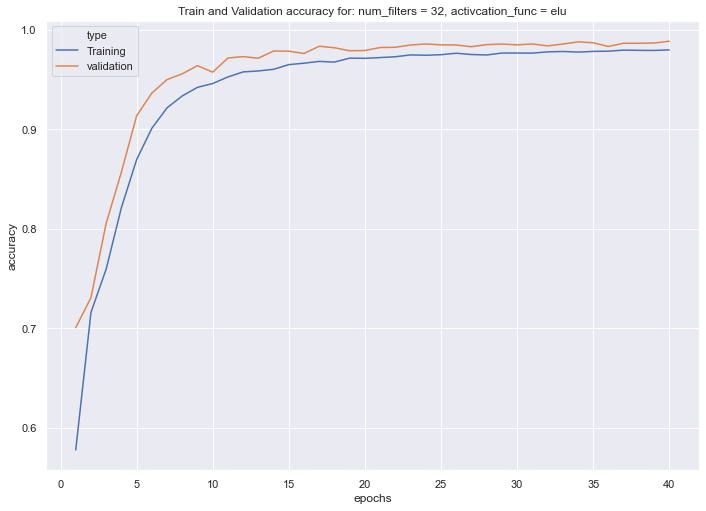

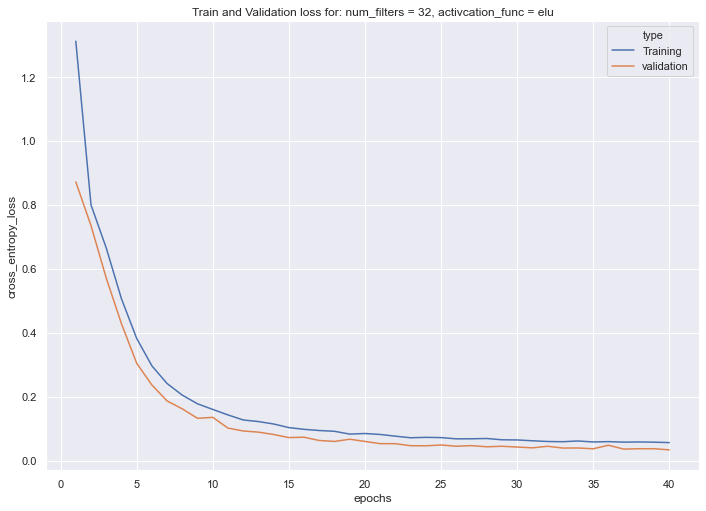

In [32]:
gen_sns_line_plots(hpo_list, 11)

## Plots for Fourth Best Configuration

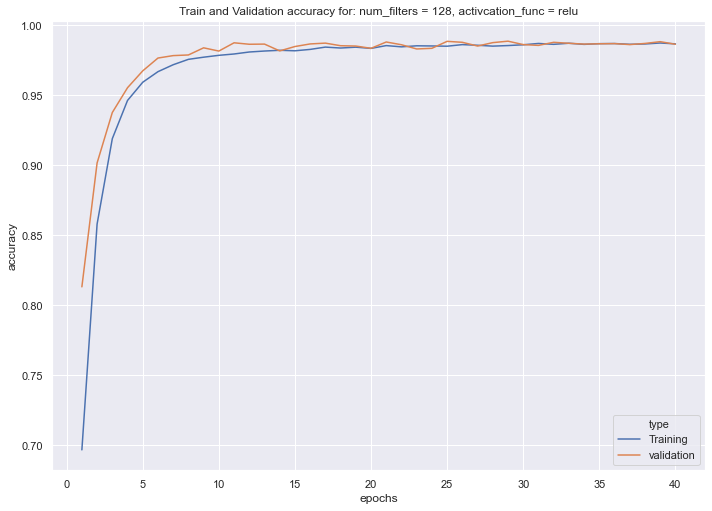

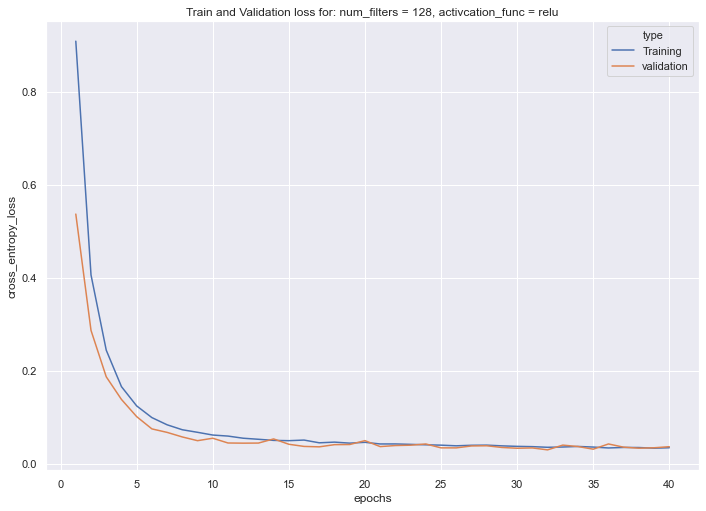

In [33]:
gen_sns_line_plots(hpo_list, 20)

## Re-running the best configuration again and saving the model

In [34]:
model = keras.Sequential(
[
    keras.Input(shape=input_shape),
    layers.Conv2D(64, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.Conv2D(64*2, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.Flatten(),
    layers.Dropout(0.05),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 3, 3, 64)          320       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 128)         32896     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 512)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 11)              

In [35]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
t1 = time.time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
t2 = time.time()
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
model.save('trained_cnn.h5')

Epoch 1/40
270/270 [==============================] - 2s 6ms/step - loss: 1.0509 - accuracy: 0.6547 - val_loss: 0.6500 - val_accuracy: 0.7668
Epoch 2/40
270/270 [==============================] - 1s 5ms/step - loss: 0.5522 - accuracy: 0.8063 - val_loss: 0.4449 - val_accuracy: 0.8500
Epoch 3/40
270/270 [==============================] - 1s 5ms/step - loss: 0.3847 - accuracy: 0.8666 - val_loss: 0.2979 - val_accuracy: 0.9076
Epoch 4/40
270/270 [==============================] - 2s 6ms/step - loss: 0.2679 - accuracy: 0.9119 - val_loss: 0.2090 - val_accuracy: 0.9352
Epoch 5/40
270/270 [==============================] - 2s 6ms/step - loss: 0.1997 - accuracy: 0.9346 - val_loss: 0.1577 - val_accuracy: 0.9571
Epoch 6/40
270/270 [==============================] - 2s 6ms/step - loss: 0.1586 - accuracy: 0.9474 - val_loss: 0.1243 - val_accuracy: 0.9642
Epoch 7/40
270/270 [==============================] - 2s 6ms/step - loss: 0.1322 - accuracy: 0.9557 - val_loss: 0.1002 - val_accuracy: 0.9698
Epoch 

In [36]:
model.save('trained_cnn.h5')